In [60]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('ggplot')    # стиль графиков
# %matplotlib inline

In [ ]:
TRAIN_SPLIT = 15000

BATCH_SIZE = 32
BUFFER_SIZE = 10000

EVALUATION_INTERVAL = 10
EPOCHS = 100

In [4]:
df = pd.read_csv('dataset_2.csv', sep=',', index_col="date")
df.head() # 18528

T     Po   Pa  Относительная влажность в %  \
date                                                                
2018-01-27 00:00:00 -5.1  760.7  0.4                         65.0   
2018-01-27 03:00:00 -6.8  761.3  0.6                         74.0   
2018-01-27 06:00:00 -6.3  761.4  0.1                         84.0   
2018-01-27 09:00:00 -4.5  761.5  0.1                         83.0   
2018-01-27 12:00:00 -3.5  761.2 -0.3                         68.0   

                     Скорость ветра  Облачность  Точка росы  Среднее давление  \
date                                                                            
2018-01-27 00:00:00             4.0         1.0       -10.7            1035.6   
2018-01-27 03:00:00             4.0         1.0       -10.7            1035.8   
2018-01-27 06:00:00             7.0         1.0        -8.6            1035.9   
2018-01-27 09:00:00             4.0         1.0        -6.9            1035.5   
2018-01-27 12:00:00             7.0         1.0        -8.6            1033.9   

                     Направление ветра_Ветер, дующий с востока  \
date                                                             
2018-01-27 00:00:00                                        0.0   
2018-01-27 03:00:00                                        0.0   
2018-01-27 06:00:00                                        0.0   
2018-01-27 09:00:00                                        0.0   
2018-01-27 12:00:00                                        0.0   

                     Направление ветра_Ветер, дующий с востоко-северо-востока  \
date                                                                            
2018-01-27 00:00:00                                                0.0          
2018-01-27 03:00:00                                                0.0          
2018-01-27 06:00:00                                                0.0          
2018-01-27 09:00:00                                                0.0          
2018-01-27 12:00:00                                                0.0          

                     ...  Направление ветра_Ветер, дующий с северо-запада  \
date                 ...                                                    
2018-01-27 00:00:00  ...                                              0.0   
2018-01-27 03:00:00  ...                                              0.0   
2018-01-27 06:00:00  ...                                              0.0   
2018-01-27 09:00:00  ...                                              0.0   
2018-01-27 12:00:00  ...                                              0.0   

                     Направление ветра_Ветер, дующий с северо-северо-востока  \
date                                                                           
2018-01-27 00:00:00                                                0.0         
2018-01-27 03:00:00                                                0.0         
2018-01-27 06:00:00                                                0.0         
2018-01-27 09:00:00                                                0.0         
2018-01-27 12:00:00                                                0.0         

                     Направление ветра_Ветер, дующий с северо-северо-запада  \
date                                                                          
2018-01-27 00:00:00                                                0.0        
2018-01-27 03:00:00                                                0.0        
2018-01-27 06:00:00                                                0.0        
2018-01-27 09:00:00                                                0.0        
2018-01-27 12:00:00                                                0.0        

                     Направление ветра_Ветер, дующий с юга  \
date                                                         
2018-01-27 00:00:00                                    1.0   
2018-01-27 03:00:00                                    1.0   
2018-01-27 06:00:00                  

In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

def create_time_steps(length):
  return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction, STEP):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future),
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction),
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [8]:
tf.random.set_seed(13)

In [9]:
features_considered = ['T', 'Относительная влажность в %', 'Точка росы']

In [10]:
features = df[features_considered]
features.head()

T  Относительная влажность в %  Точка росы
date                                                             
2018-01-27 00:00:00 -5.1                         65.0       -10.7
2018-01-27 03:00:00 -6.8                         74.0       -10.7
2018-01-27 06:00:00 -6.3                         84.0        -8.6
2018-01-27 09:00:00 -4.5                         83.0        -6.9
2018-01-27 12:00:00 -3.5                         68.0        -8.6

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

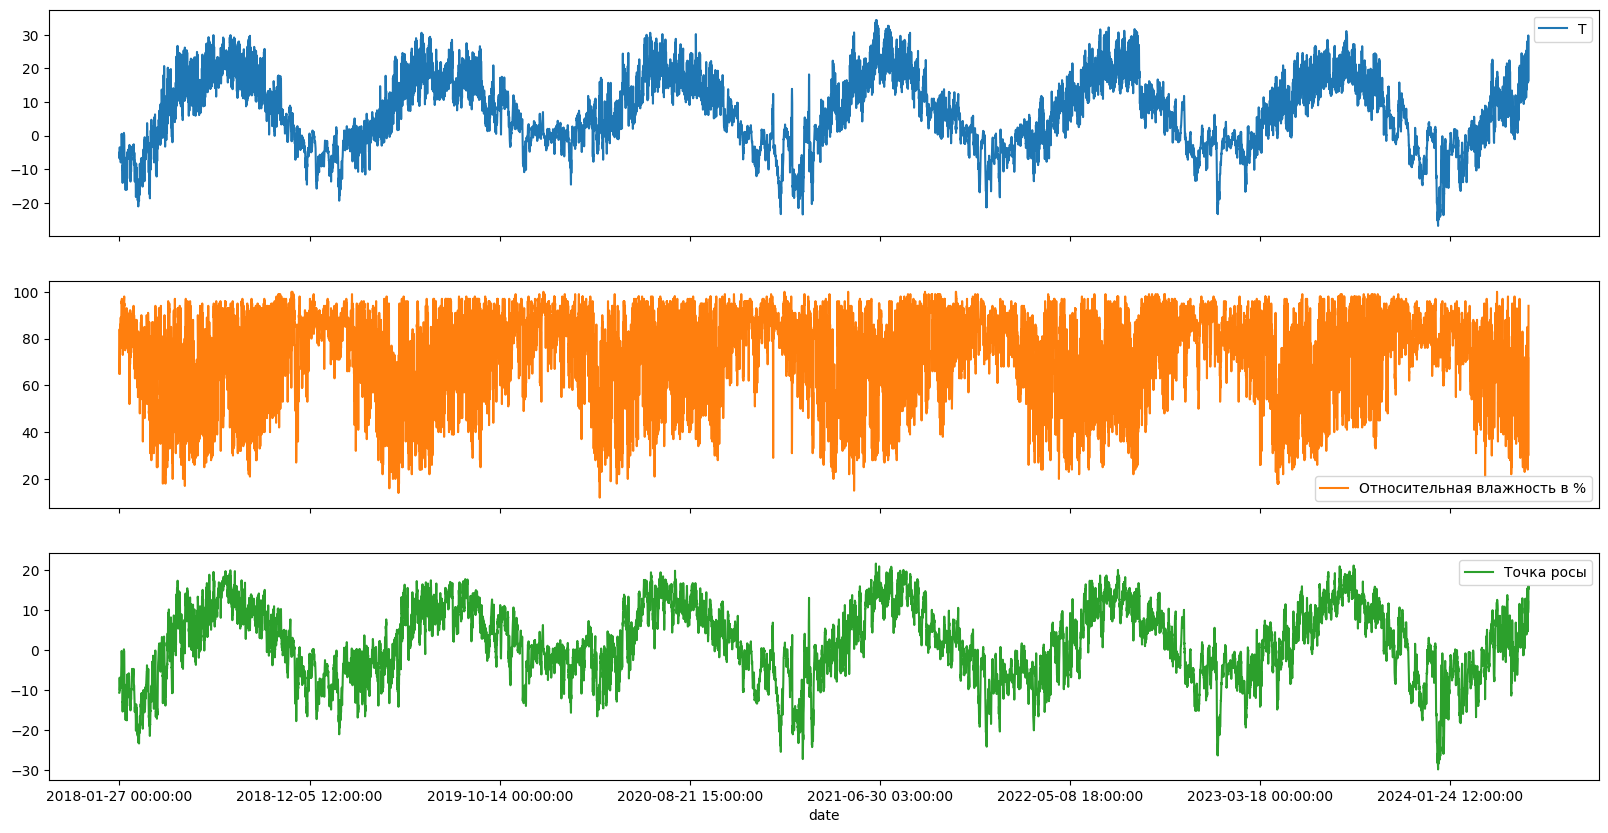

In [11]:
features.plot(subplots=True, figsize=(20,10))

In [61]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [62]:
dataset = (dataset - data_mean) / data_std

In [64]:
past_history = 240
future_target = 56
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [70]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (240, 3)

 Target temperature to predict : (56,)


In [49]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

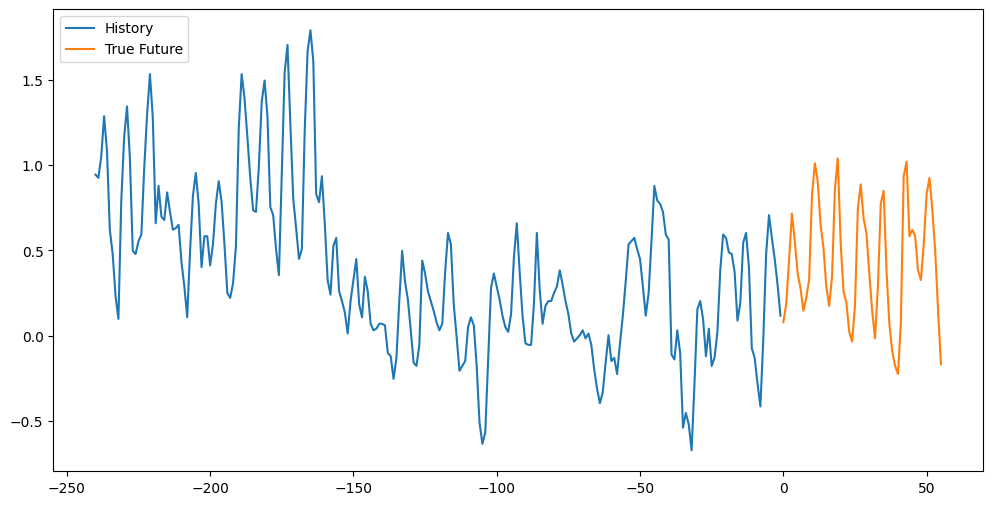

In [51]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]), STEP)

In [53]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(56))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [54]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
(32, 56)


In [92]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.3647 - val_loss: 0.3713
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.3669 - val_loss: 0.4068
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.3611 - val_loss: 0.3755
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.3582 - val_loss: 0.4087
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.3605 - val_loss: 0.3680
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.3561 - val_loss: 0.4094
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.3599 - val_loss: 0.3732
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.3670 - val_loss: 0.4030
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.3709 - val_loss: 0.3852
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.3589 - val_loss: 0.4032
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.3418 - val_loss: 0.3763
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1

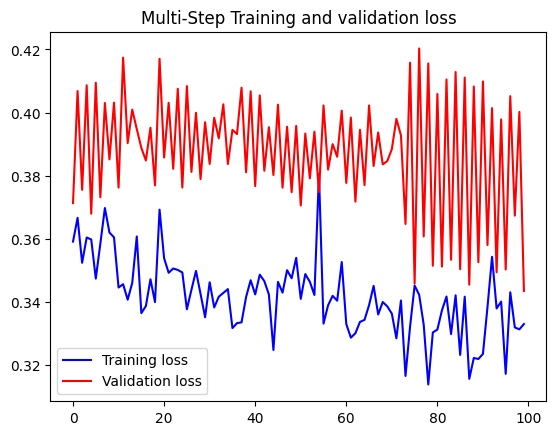

In [94]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


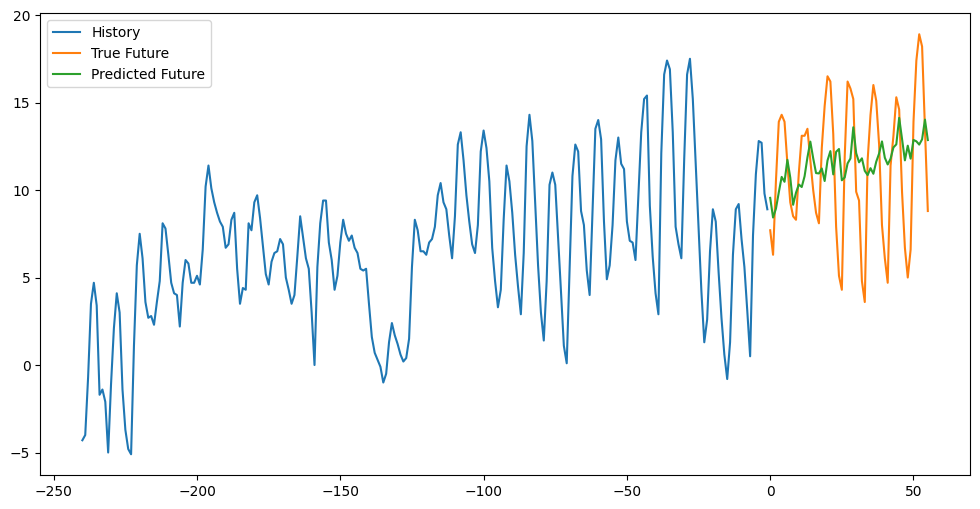

In [95]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0] * data_std[0] + data_mean[0], y[0] * data_std[0] + data_mean[0], multi_step_model.predict(x)[0] * data_std[0] + data_mean[0])